<a href="https://colab.research.google.com/github/m10singh94/ClassificationAndBoundingBoxPrediction/blob/main/ClassificationWithBoundingBoxPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classification with Bounding Box Prediction
We will create a  `ViT model` using Transfer Learning to detect the class of image (either a dog or a cat) and also the bounding box, and try to demonstrate a demo of the model in Gradio in HuggingFace Space.

## 1 Starting with Importing all the files
* torch
* torchvision
* matplotlib
* torchinfo


In [1]:
# importing torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

from pathlib import Path
import os
import zipfile
import requests
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import cv2
import pandas as pd
from bboxregressiongenerator import DataGenerator

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2 Getting Data

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maitsingh","key":"b48511fa6d8df5b23fc91c558e9b263e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           7269        229  1.0              
nelgiriyewithana/global-youtube-statistics-2023            Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          17457        563  1.0              
joebeachcapital/students-performance                       Students Performance                             2KB  2023-08-31 00:50:11           2180         56  1.0              
joebeachcapital/restaurant-reviews                         Restaurant Reviews                               1M

In [5]:
! kaggle datasets download -d andrewmvd/dog-and-cat-detection

100% 1.03G/1.03G [00:55<00:00, 23.7MB/s]
100% 1.03G/1.03G [00:55<00:00, 19.9MB/s]


In [6]:
data_path = Path("data/")
image_path = data_path / "cat_dog"

if image_path.is_dir():
  print(f"{image_path} exists.")
else:
  print(f"{image_path} doesn't exist, creating one.")
  image_path.mkdir(parents=True, exist_ok=True)

# As dataset's already downloaded, changing the directory
!mv ./dog-and-cat-detection.zip ./data/cat_dog/dog-and-cat-detection.zip

with zipfile.ZipFile(image_path / "dog-and-cat-detection.zip", "r") as zip_ref:
  print("Unzipping cat and dog...")
  zip_ref.extractall(image_path)
  print("Unzipping completed!")

!rm ./data/cat_dog/dog-and-cat-detection.zip
print("Directory ready to be used!")

data/cat_dog doesn't exist, creating one.
Unzipping cat and dog...
Unzipping completed!
Directory ready to be used!


## 3 Plot an image and it's bounding box

In [7]:
directory = image_path / 'annotations'
annotations = os.listdir(directory)

In [8]:
with open(os.path.join(directory,'Cats_Test0.xml'), 'r') as f:
        file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

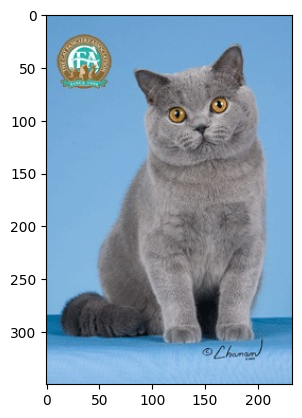

In [9]:
import cv2
img = cv2.imread(str(image_path) + "/images/Cats_Test0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

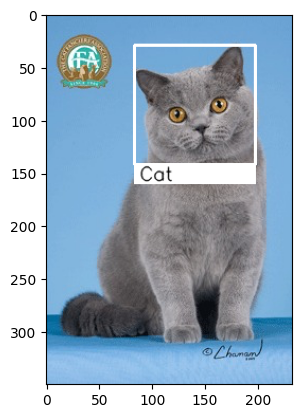

In [11]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=1

img = cv2.rectangle(img, (xmin, ymin), (xmax,ymax), (255,255,255), 2)
img = cv2.rectangle(img,(xmin,ymax),(xmax,ymax+18),(255,255,255),-1)
img = cv2.putText(img,"Cat",(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

plt.imshow(img)

## 4 Preparing dataset
Converting `.xml` files to dataframes that can be used as dataset.

In [17]:
images_desc = []

for file in annotations:
  with open(os.path.join(directory,file), 'r') as f:
    content = f.read()

  data = BeautifulSoup(content, 'xml')

  filename = data.find("filename").text.strip()
  width = int(data.find("size").width.text)
  height = int(data.find("size").height.text)
  class_name = data.find("object").find("name").text
  xmin = int(data.find("object").find("bndbox").find("xmin").text) / width
  ymin = int(data.find("object").find("bndbox").find("ymin").text) / height
  xmax = int(data.find("object").find("bndbox").find("xmax").text) / width
  ymax = int(data.find("object").find("bndbox").find("ymax").text) / height

  images_desc.append([filename, class_name, xmin, ymin, xmax, ymax])

In [18]:
# import pandas as pd
df = pd.DataFrame(images_desc,columns=['filename','class','xmin','ymin','xmax','ymax'])
df.drop_duplicates(subset=['filename'],inplace=True)
df['class'] = df['class'].apply(lambda x: 1.0 if x=='dog' else 0.0)
df.head()

,filename,class,xmin,ymin,xmax,ymax
0,Cats_Test1207.png,1.0,0.334000,0.030030,0.740000,0.945946
1,Cats_Test1836.png,1.0,0.160000,0.236842,0.346000,0.427632
2,Cats_Test52.png,1.0,0.092000,0.099099,0.362000,0.471471
3,Cats_Test1835.png,1.0,0.291291,0.218000,0.735736,0.466000
4,Cats_Test743.png,1.0,0.410256,0.210000,0.766382,0.478000


In [22]:
class_dict = {'Dog':1.0, 'Cat':0.0}
class_dict.keys(), class_dict.values()

(dict_keys(['Dog', 'Cat']), dict_values([1.0, 0.0]))

In [19]:
df = df.sample(frac=1).reset_index(drop=True)
train = df.head(3000)
test = df.tail(686).reset_index(drop=True)

In [48]:
%%writefile utils.py
"""
Contains DataGenrator and creates a dataset
"""

import torch
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import os
import pathlib
from PIL import Image

class CustomDatasetGenerator(Dataset):

  def __init__(self, df, image_dir, class_dict, transform=None) -> None:
    self.df = df.copy()
    self.image_dir = image_dir
    self.paths = list(df['filename'])
    self.transform = transform
    self.classes = class_dict.keys()
    self.class_to_idx = class_dict.values()

  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_dir / image_path)

  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int, List[int]]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_idx  = self.df['class'][index]
    xmin = df['xmin'][index]
    ymin = df['ymin'][index]
    xmax = df['xmax'][index]
    ymax = df['ymax'][index]

    # Transform if necessary
    if self.transform:
        return self.transform(img), class_idx, list(xmin, ymin, xmax, ymax)
    else:
        return img, class_idx, list(xmin, ymin, xmax, ymax)

Overwriting utils.py


In [49]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

In [50]:
from utils import CustomDatasetGenerator
image_dir = image_path / "images"
train_data_custom = CustomDatasetGenerator(df=train,
                                           image_dir=image_dir,
                                           class_dict=class_dict,
                                           transform=train_transform)
test_data_custom = CustomDatasetGenerator(df=test,
                                          image_dir=image_dir,
                                          class_dict=class_dict,
                                          transform=test_transform)
train_data_custom, test_data_custom

TypeError: ignored

In [39]:
len(train_data_custom), len(test_data_custom)

(3000, 686)

In [40]:
train_dataloader = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7af782f96860>,
 <torch.utils.data.dataloader.DataLoader at 0x7af782f953f0>)

In [41]:
img, label, coords = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f'Coords shape: {coords.shape}')

FileNotFoundError: ignored